In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

For detailed comments about the code look at the first quarter analysis.

# Second quarter

First all the products are aggregated per category, taking as price of the category the mean of the log(price_changes) 

In [2]:
pdsecond = pd.read_csv('dataset/second_quarter.csv', index_col=0)

In [3]:
pdsecond

,comp_date,seller_id,seller_name,product_id,price,min(price),max(price),coded_cat1,coded_cat2,coded_cat3,coded_brand,price_change,price_change_log,price_change_var
23,2021-04-01,23,C,101767,1499,1392,2590,1375,1564,2715,279,NaN,NaN,4.444444e+02
28,2021-04-01,23,C,102342,9999,6418,15089,2180,613,1826,376,NaN,NaN,1.361111e+05
81,2021-04-01,23,C,103859,4399,3599,5999,2180,834,3016,453,NaN,NaN,6.702871e+03
129,2021-04-01,23,C,105491,15999,13485,17990,1676,2832,1273,775,NaN,NaN,NaN
181,2021-04-01,23,C,107419,4999,4426,5690,885,2633,3676,329,NaN,NaN,2.777778e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112112,2021-06-30,490,L,164698,35999,11990,35999,2880,498,1732,377,0.0,0.0,5.832000e+06
2112130,2021-06-30,490,L,166528,21999,18488,21999,1354,1600,1065,542,0.0,0.0,8.988764e+04
2112134,2021-06-30,490,L,176877,15999,13214,24999,1354,1600,1192,710,0.0,0.0,4.505618e+05
2112143,2021-06-30,490,L,183399,13990,9990,15990,1676,1258,2369,522,0.0,0.0,4.444444e+04


In [4]:
ge=pdsecond.groupby(['comp_date','seller_id','coded_cat1'])['price_change_log'].mean().reset_index()
ge['comp_date'] = pd.to_datetime(ge['comp_date'])

pivot={}
for i in pdsecond['coded_cat1'].unique():
    pivot[i] = ge[ge['coded_cat1']==i].pivot(index='comp_date', columns='seller_id', values='price_change_log')

for i in pdsecond['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = pivot[i]

Dropping all the seller that have all null values for a specific category

In [5]:
c=0
for i in pdsecond['coded_cat1'].unique():
    for j in globals()['pivot{}'.format(i)].columns:
        if np.isnan(globals()['pivot{}'.format(i)][j]).all() == True or (globals()['pivot{}'.format(i)][j]).sum() == 0:
            print(f'for the seller {j} the category {i} has all null values or zeros, so we drop it')
            globals()['pivot{}'.format(i)].drop(j, inplace=True, axis=1)
        else:
            c += 1

if c == 104:
    print('None of the category has all null values for each of sellers')

In [6]:
#fill na in all the pivot
for i in pdsecond['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='ffill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='bfill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(0)

## Pivot 1163

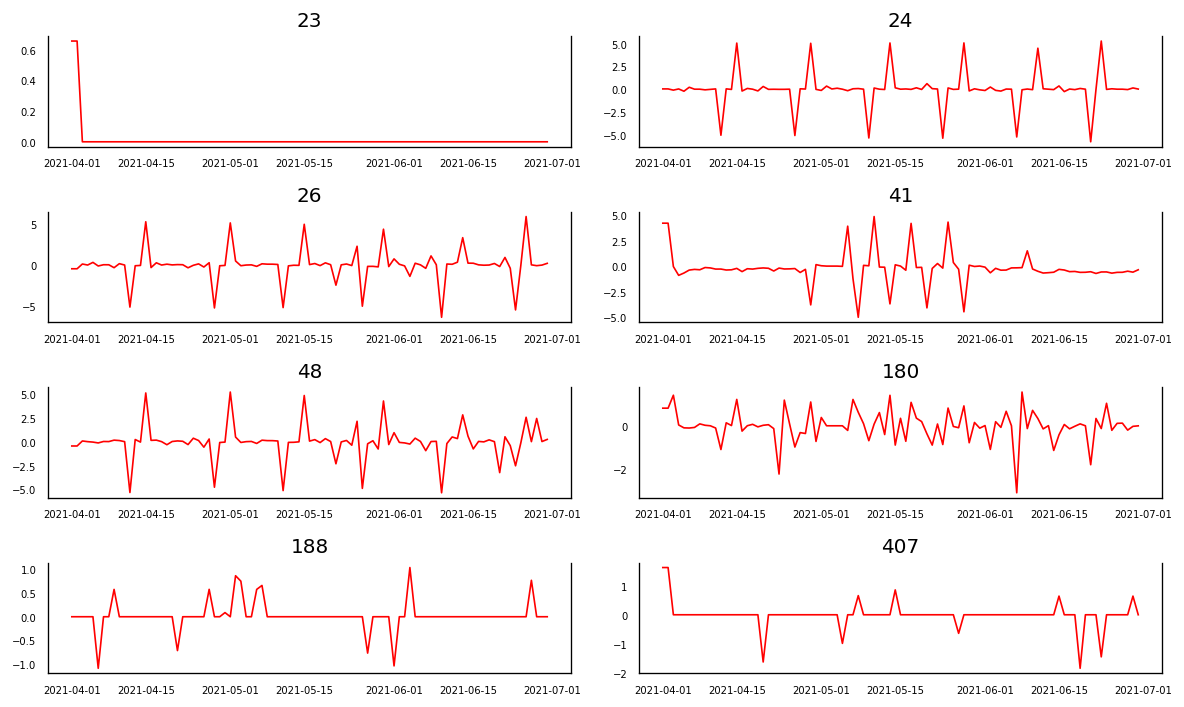

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1163[pivot1163.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot1163.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

dropping seller 23 becuase it has too many null values

In [8]:
pivot1163.drop(23,inplace=True,axis=1)

In [9]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [11]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8756
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5709
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [12]:
pivot1163 = pivot1163.diff().dropna()

In [13]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.1941
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0173
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [14]:
cointegration_test(pivot1163)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  394.29    > 143.6691  =>   True
26     ::  301.83    > 111.7797  =>   True
41     ::  227.33    > 83.9383   =>   True
48     ::  159.67    > 60.0627   =>   True
180    ::  113.8     > 40.1749   =>   True
188    ::  70.0      > 24.2761   =>   True
407    ::  42.02     > 12.3212   =>   True
490    ::  18.41     > 4.1296    =>   True


In [15]:
#VAR model on df_pivot
model = VAR(pivot1163)
x = model.select_order(maxlags=8)
x.summary()

c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.6836,0.9184*,1.981,0.7779
1,-0.7593,1.354,0.4713,0.08912
2,-1.345,2.647,0.2736,0.2577
3,-2.043,3.827,0.1522,0.3141
4,-2.986,4.762,0.07427*,0.1249
5,-3.026,6.601,0.1068,0.8395
6,-3.425,8.080,0.1414,1.194
7,-4.446,8.937,0.1583,0.9270
8,-6.883*,8.380,0.09948,-0.7551*


In [16]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:05:38
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    8.37955
Nobs:                     82.0000    HQIC:                 -0.755067
Log likelihood:          -128.638    FPE:                  0.0994850
AIC:                     -6.88258    Det(Omega_mle):     0.000932674
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.111059         0.256962            0.432           0.666
L1.24         -0.494595         0.268843           -1.840           0.066
L1.26          0.073149         0.821233            0.089           0.929
L1.41         -0.

# PIVOT 1375

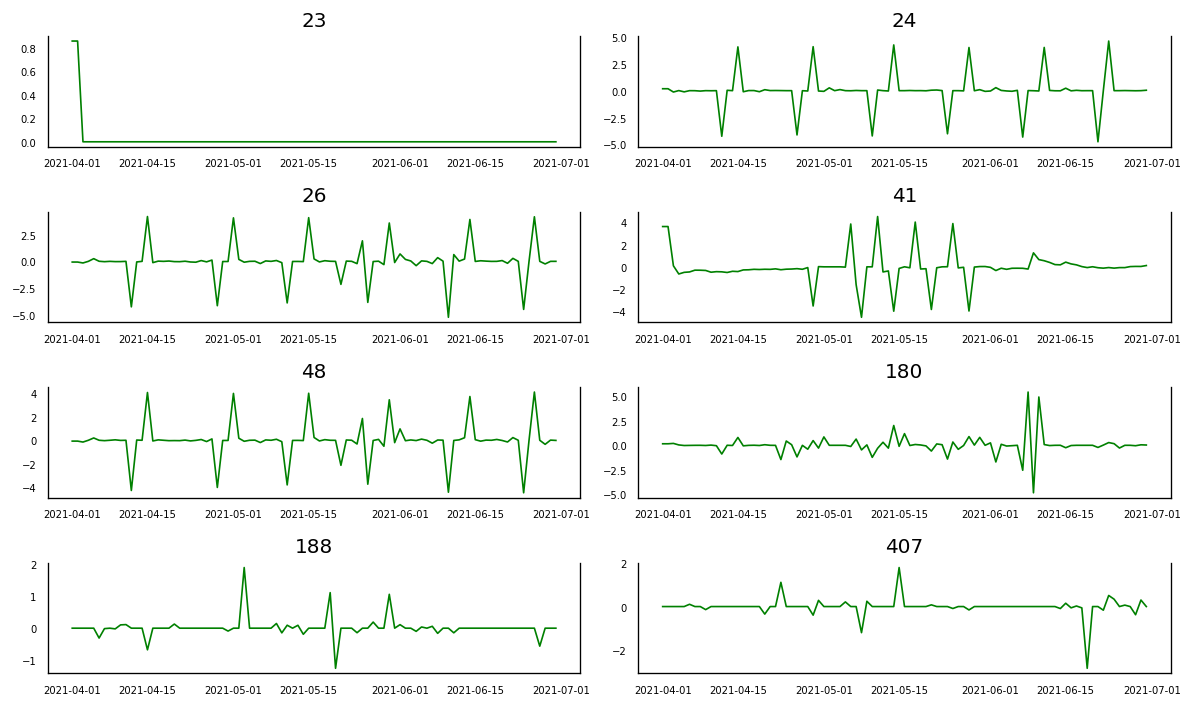

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1375[pivot1375.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1375.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [18]:
pivot1375.drop(23,inplace=True,axis=1)

In [19]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.8633
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9139
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [20]:
pivot1375 = pivot1375.diff().dropna()

In [21]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0638
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9844
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [22]:
cointegration_test(pivot1375)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  424.83    > 143.6691  =>   True
26     ::  283.43    > 111.7797  =>   True
41     ::  205.64    > 83.9383   =>   True
48     ::  144.54    > 60.0627   =>   True
180    ::  102.04    > 40.1749   =>   True
188    ::  61.52     > 24.2761   =>   True
407    ::  35.44     > 12.3212   =>   True
490    ::  14.59     > 4.1296    =>   True


In [23]:

#VAR model on df_pivot
model = VAR(pivot1375)
x = model.select_order(maxlags=5)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-1.044,-0.8141,0.3520,-0.9516
1,-4.109,-2.040*,0.01653,-3.277*
2,-4.487,-0.5787,0.01176,-2.915
3,-4.835,0.9127,0.009173,-2.523
4,-5.823,1.764,0.004174*,-2.771
5,-6.176*,3.250,0.004182,-2.385


In [24]:

model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:05:44
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    3.24969
Nobs:                     85.0000    HQIC:                  -2.38477
Log likelihood:          -374.395    FPE:                 0.00418193
AIC:                     -6.17607    Det(Omega_mle):     0.000179376
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.019987         0.169007            0.118           0.906
L1.24         -0.734782         0.180222           -4.077           0.000
L1.26          0.667321         1.986375            0.336           0.737
L1.41          0.

# PIVOT 2180

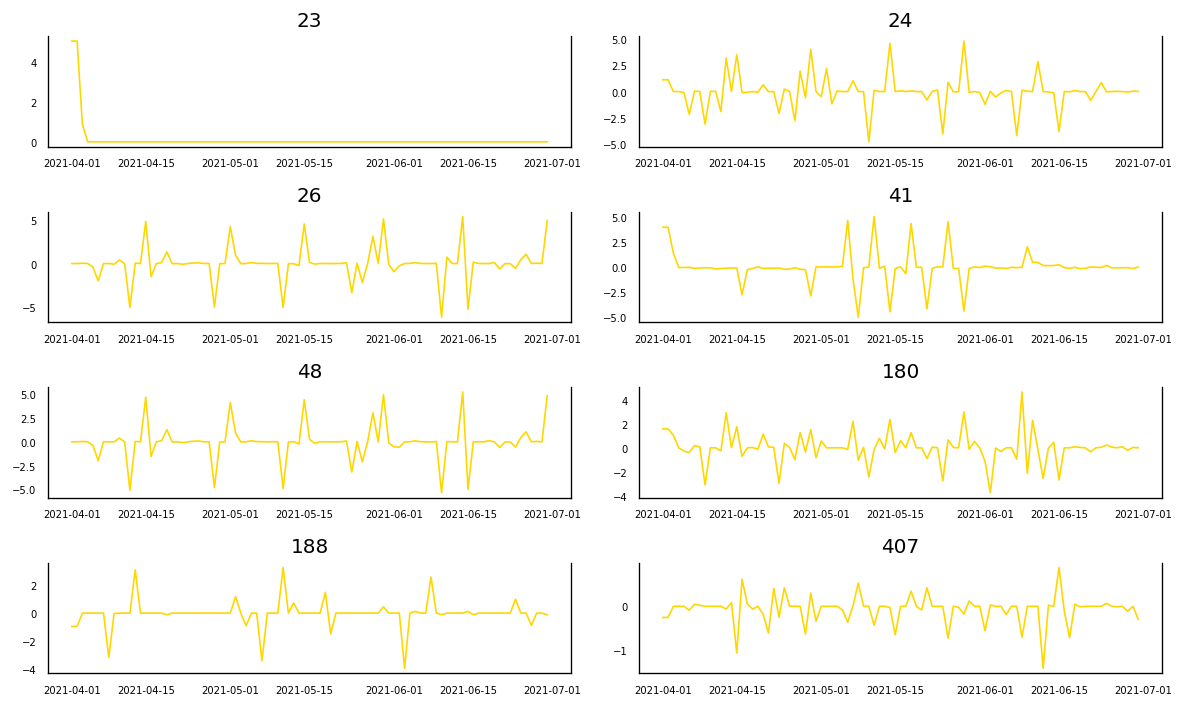

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2180[pivot2180.columns[i]]
    ax.plot(data, color='gold', linewidth=1)
    # Decorations
    ax.set_title(pivot2180.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
pivot2180.drop(23,inplace=True,axis=1)

In [27]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.0638
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9844
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [28]:
pivot2180 = pivot2180.diff().dropna()

In [29]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2795
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8603
 No. Lags Chosen       = 4
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [30]:
cointegration_test(pivot2180)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  517.36    > 143.6691  =>   True
26     ::  402.37    > 111.7797  =>   True
41     ::  299.24    > 83.9383   =>   True
48     ::  222.83    > 60.0627   =>   True
180    ::  160.49    > 40.1749   =>   True
188    ::  105.95    > 24.2761   =>   True
407    ::  58.81     > 12.3212   =>   True
490    ::  24.85     > 4.1296    =>   True


In [31]:

#VAR model on df_pivot
model = VAR(pivot2180)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,1.863,2.097,6.440,1.957
1,-0.5835,1.530*,0.5619,0.2650
2,-1.612,2.380,0.2096,-0.008973
3,-2.646,3.224,0.08323,-0.2896
4,-3.059,4.690,0.06906,0.05227
5,-4.012,5.615,0.03984,-0.1468
6,-5.944,5.561,0.01139,-1.325
7,-7.384,6.000,0.008387,-2.011
8,-12.87*,2.393,0.0002499*,-6.742*


In [32]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:05:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.39265
Nobs:                     82.0000    HQIC:                  -6.74196
Log likelihood:           116.825    FPE:                0.000249851
AIC:                     -12.8695    Det(Omega_mle):     2.34236e-06
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.013640         0.117814           -0.116           0.908
L1.24         -0.488352         0.328063           -1.489           0.137
L1.26         -6.405852         3.006038           -2.131           0.033
L1.41         -0.

# PIVOT 1676

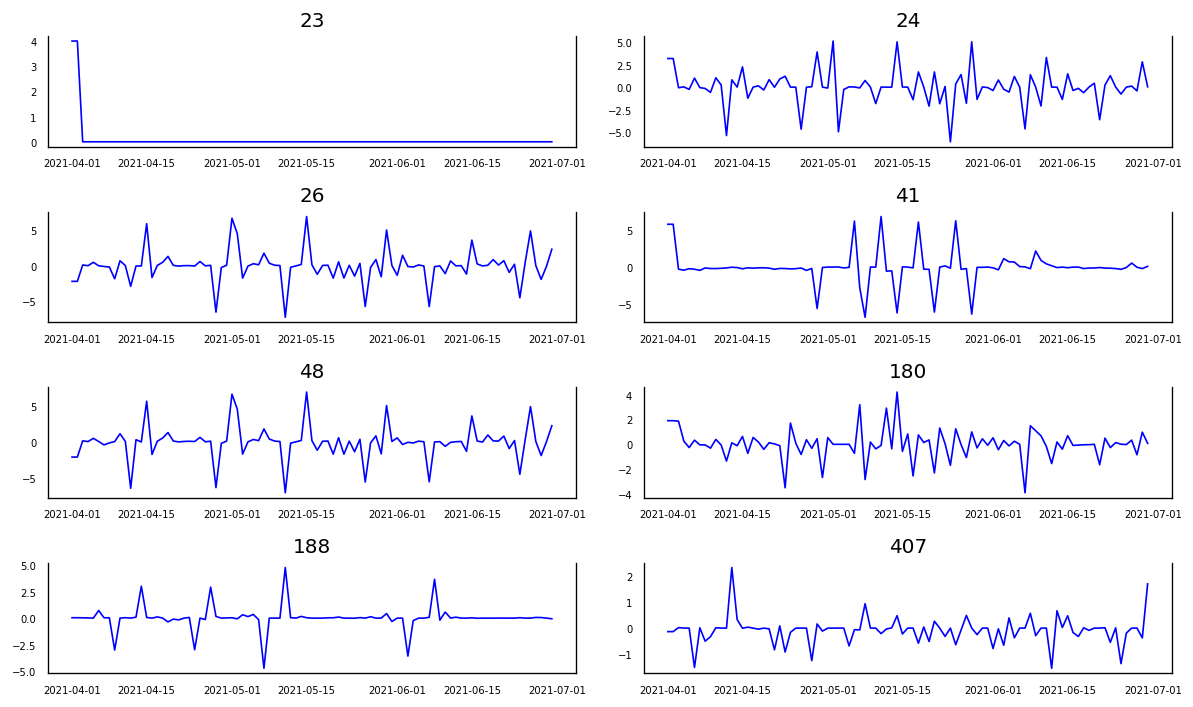

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1676[pivot1676.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(pivot1676.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [34]:
pivot1676.drop(23,inplace=True,axis=1)

In [35]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2299
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3019
 No. Lags Chosen       = 0
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [36]:
pivot1676 = pivot1676.diff().dropna()

In [37]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7866
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.921
 No. Lags Chosen       = 4
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Sta

In [38]:
cointegration_test(pivot1676)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  407.3     > 143.6691  =>   True
26     ::  293.02    > 111.7797  =>   True
41     ::  226.58    > 83.9383   =>   True
48     ::  172.54    > 60.0627   =>   True
180    ::  119.74    > 40.1749   =>   True
188    ::  72.85     > 24.2761   =>   True
407    ::  32.38     > 12.3212   =>   True
490    ::  9.76      > 4.1296    =>   True


In [39]:

#VAR model on df_pivot
model = VAR(pivot1676)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,7.297,7.532,1476.,7.391
1,4.849,6.963*,128.6,5.698
2,4.585,8.576,102.9,6.187
3,3.926,9.796,59.52,6.283
4,3.162,10.91,34.73,6.273
5,2.285,11.91,21.62,6.150
6,1.854,13.36,27.74,6.473
7,0.7270,14.11,27.93,6.100
8,-3.325*,11.94,3.491*,2.803*


In [40]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:05:54
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    11.9376
Nobs:                     82.0000    HQIC:                   2.80295
Log likelihood:          -274.517    FPE:                    3.49126
AIC:                     -3.32456    Det(Omega_mle):       0.0327307
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.017936         0.158322            0.113           0.910
L1.24         -0.654312         0.207585           -3.152           0.002
L1.26          0.065422         0.430707            0.152           0.879
L1.41          0.

 # PIVOT 2259

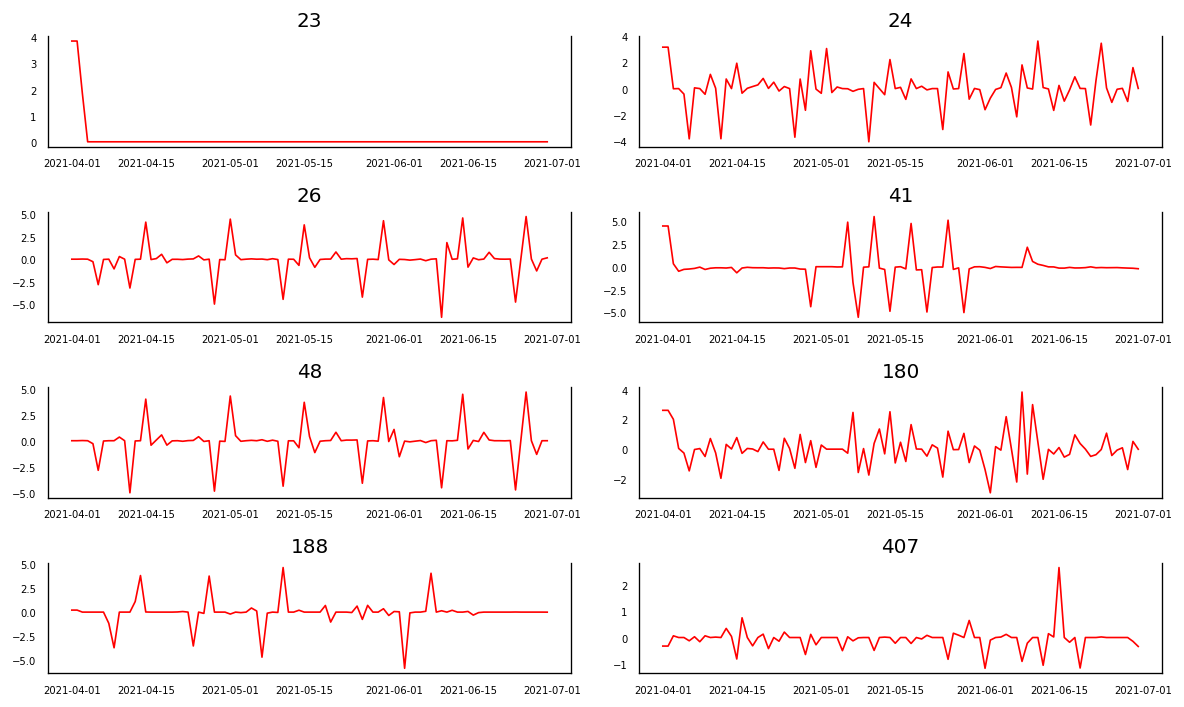

In [41]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2259[pivot2259.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2259.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [42]:
pivot2259.drop(23,inplace=True,axis=1)

In [43]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5013
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6387
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [44]:
pivot2259 = pivot2259.diff().dropna()

In [45]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5207
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6804
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [46]:
cointegration_test(pivot2259)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  541.39    > 143.6691  =>   True
26     ::  406.75    > 111.7797  =>   True
41     ::  309.4     > 83.9383   =>   True
48     ::  213.94    > 60.0627   =>   True
180    ::  148.37    > 40.1749   =>   True
188    ::  98.78     > 24.2761   =>   True
407    ::  60.19     > 12.3212   =>   True
490    ::  28.63     > 4.1296    =>   True


In [47]:

#VAR model on df_pivot
model = VAR(pivot2259)
x = model.select_order(maxlags=7)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,3.905,4.138,49.63,3.998
1,1.692,3.790*,5.468,2.535
2,1.530,5.494,4.842,3.123
3,1.212,7.041,3.921,3.554
4,0.2972,7.991,1.951,3.388
5,-0.6004,8.958,1.170,3.240
6,-1.986,9.438,0.5598*,2.604
7,-2.823*,10.47,0.7097,2.515*


In [48]:

model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:00
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    10.4657
Nobs:                     83.0000    HQIC:                   2.51540
Log likelihood:          -369.004    FPE:                   0.709654
AIC:                     -2.82339    Det(Omega_mle):       0.0108305
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.015729         0.143015            0.110           0.912
L1.24         -1.175105         0.226811           -5.181           0.000
L1.26          0.345978         0.572181            0.605           0.545
L1.41         -0.

# PIVOT 885

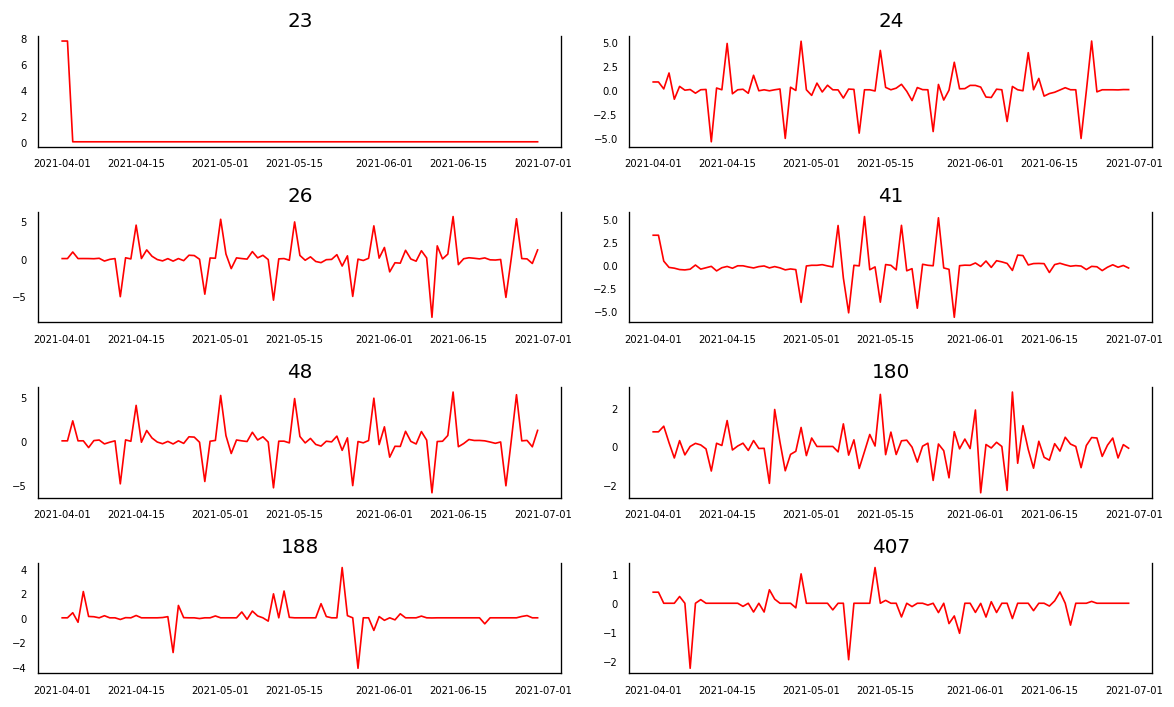

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot885[pivot885.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot885.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [50]:
pivot885.drop(23,inplace=True,axis=1)

In [51]:
 
for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2915
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6328
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [52]:
 for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2915
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6328
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [53]:
cointegration_test(pivot885)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  227.51    > 143.6691  =>   True
26     ::  162.68    > 111.7797  =>   True
41     ::  120.46    > 83.9383   =>   True
48     ::  80.0      > 60.0627   =>   True
180    ::  50.82     > 40.1749   =>   True
188    ::  31.28     > 24.2761   =>   True
407    ::  17.2      > 12.3212   =>   True
490    ::  4.69      > 4.1296    =>   True


In [54]:
#VAR model on df_pivot
model = VAR(pivot885)
x = model.select_order(maxlags=8)
x.summary()

c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-2.671,-2.438*,0.06917*,-2.578*
1,-2.256,-0.1573,0.1055,-1.413
2,-1.654,2.309,0.2005,-0.06184
3,-1.635,4.193,0.2274,0.7065
4,-1.290,6.404,0.3990,1.801
5,-1.022,8.537,0.7678,2.819
6,-1.377,10.05,1.029,3.212
7,-1.645,11.64,2.306,3.694
8,-3.370*,11.78,2.597,2.718


In [55]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:09
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    11.7839
Nobs:                     83.0000    HQIC:                   2.71783
Log likelihood:          -282.309    FPE:                    2.59693
AIC:                     -3.37027    Det(Omega_mle):       0.0254092
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.285810         0.349274            0.818           0.413
L1.24          0.100507         0.283135            0.355           0.723
L1.26         -2.622561         1.612585           -1.626           0.104
L1.41         -0.

# PIVOT 2880

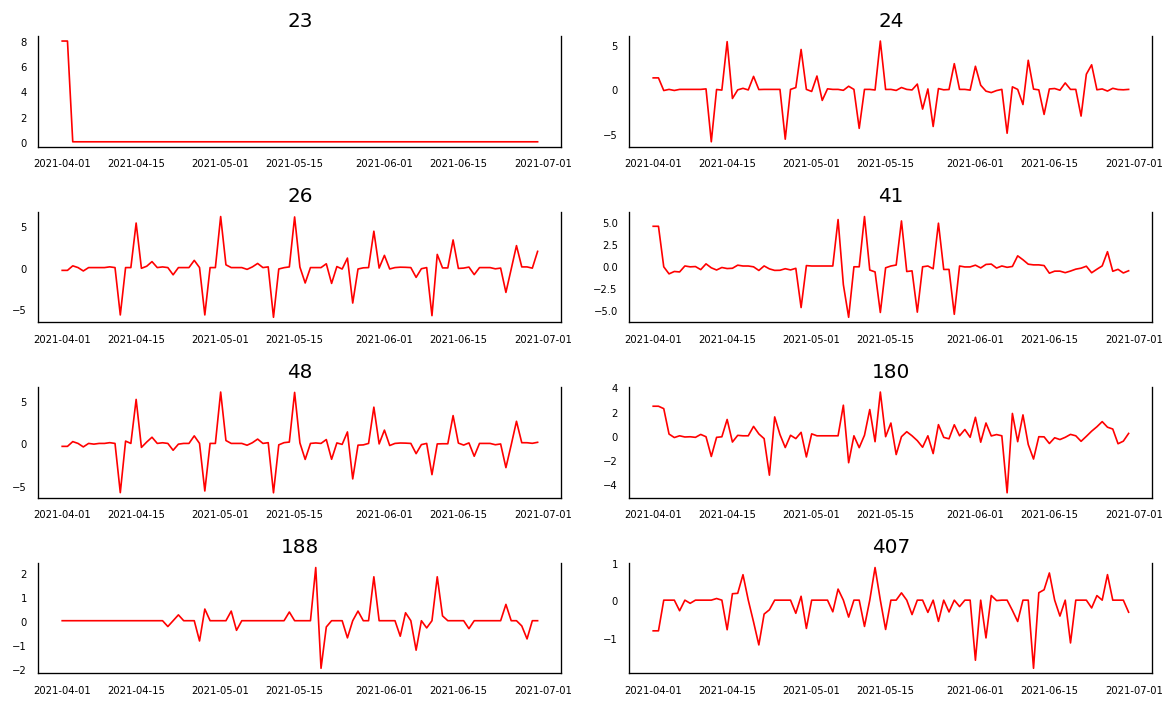

In [56]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2880[pivot2880.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2880.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

dropping the seller 23 because it has too many zeros values

In [57]:
pivot2880.drop(23,inplace=True,axis=1)

In [58]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3239
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3918
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [59]:
pivot2880 = pivot2880.diff().dropna()

In [60]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6715
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8515
 No. Lags Chosen       = 4
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [61]:
cointegration_test(pivot2880)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  397.31    > 143.6691  =>   True
26     ::  286.15    > 111.7797  =>   True
41     ::  217.66    > 83.9383   =>   True
48     ::  151.84    > 60.0627   =>   True
180    ::  105.57    > 40.1749   =>   True
188    ::  68.89     > 24.2761   =>   True
407    ::  36.29     > 12.3212   =>   True
490    ::  10.21     > 4.1296    =>   True


In [62]:

#VAR model on df_pivot
model = VAR(pivot2880)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,3.876,4.110,48.21,3.970
1,1.411,3.524*,4.128,2.259
2,1.135,5.126,3.266,2.737
3,0.6714,6.541,2.297,3.028
4,-0.3066,7.442,1.082,2.804
5,-0.8559,8.771,0.9352,3.009
6,-1.735,9.771,0.7665,2.885
7,-2.921,10.46,0.7276,2.452
8,-5.552*,9.710,0.3763*,0.5754*


In [63]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:16
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    9.70999
Nobs:                     82.0000    HQIC:                  0.575378
Log likelihood:          -183.186    FPE:                   0.376324
AIC:                     -5.55213    Det(Omega_mle):      0.00352805
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.010761         0.221825           -0.049           0.961
L1.24         -0.732791         0.351803           -2.083           0.037
L1.26         -0.808722         1.468159           -0.551           0.582
L1.41         -0.

# PIVOT 1127

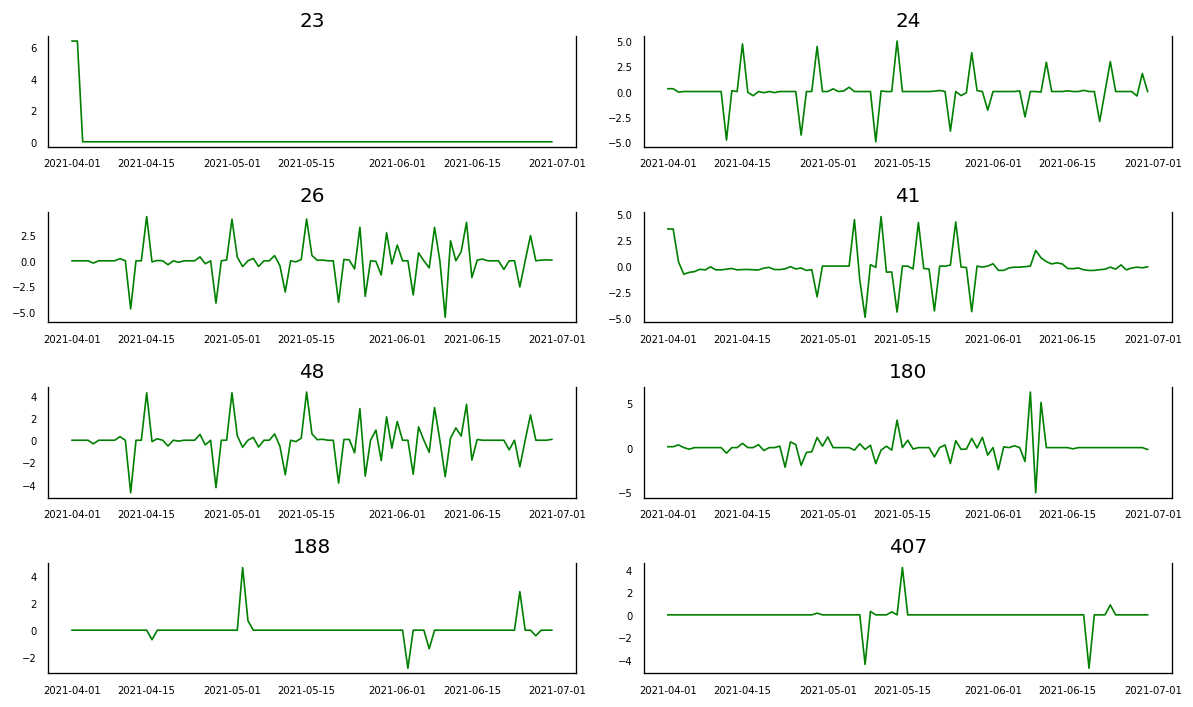

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1127[pivot1127.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1127.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [65]:
pivot1127.drop(23,inplace=True,axis=1)

In [66]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6753
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0538
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [67]:
pivot1127 = pivot1127.diff().dropna()

In [68]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.5415
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3901
 No. Lags Chosen       = 7
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [69]:
cointegration_test(pivot1127)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  470.52    > 143.6691  =>   True
26     ::  337.1     > 111.7797  =>   True
41     ::  245.59    > 83.9383   =>   True
48     ::  160.55    > 60.0627   =>   True
180    ::  103.25    > 40.1749   =>   True
188    ::  55.45     > 24.2761   =>   True
407    ::  30.56     > 12.3212   =>   True
490    ::  11.74     > 4.1296    =>   True


In [70]:

#VAR model on df_pivot
model = VAR(pivot1127)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,4.365,4.600,78.68,4.460
1,1.567,3.680*,4.825,2.415
2,1.435,5.427,4.411,3.038
3,1.078,6.948,3.449,3.435
4,0.6319,8.380,2.767,3.743
5,-0.002600,9.624,2.195,3.862
6,-1.607,9.898,0.8705,3.012
7,-4.224,9.160,0.1977,1.149
8,-7.195*,8.067,0.07277*,-1.068*


In [71]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:25
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    8.06681
Nobs:                     82.0000    HQIC:                  -1.06780
Log likelihood:          -115.816    FPE:                  0.0727676
AIC:                     -7.19531    Det(Omega_mle):     0.000682198
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.063532         0.226881            0.280           0.779
L1.24         -0.841844         0.410820           -2.049           0.040
L1.26          1.045897         1.558894            0.671           0.502
L1.41         -0.

# PIVOT 1354

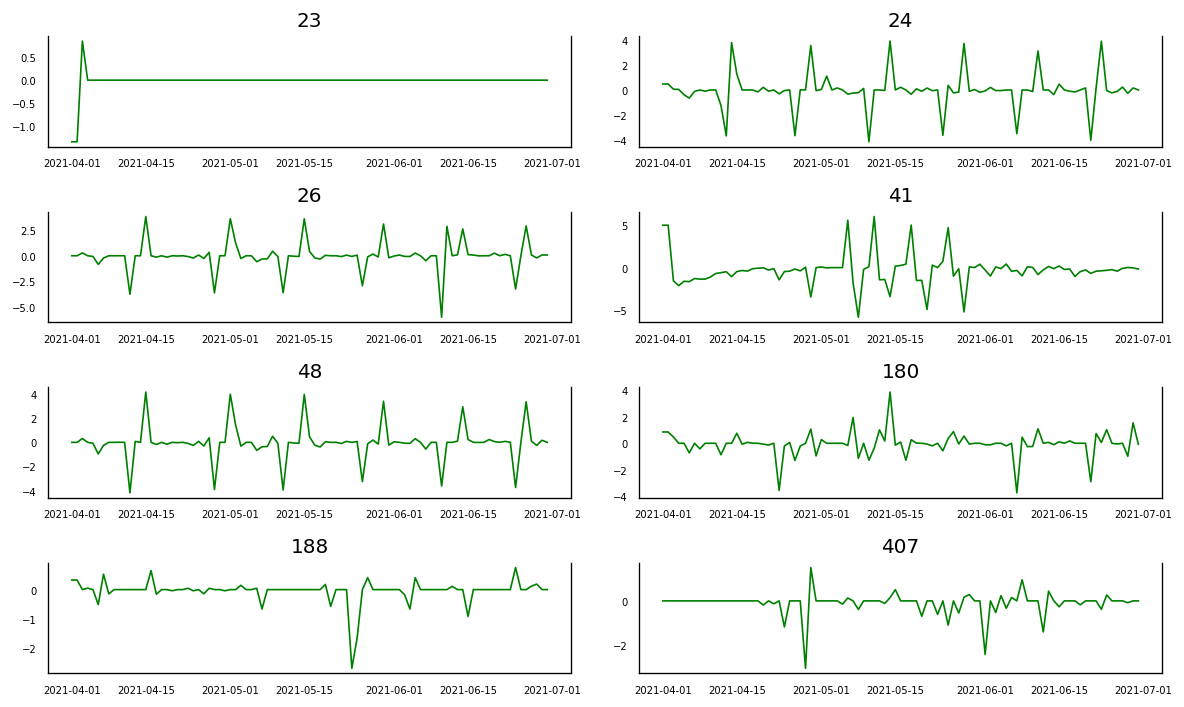

In [72]:

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1354[pivot1354.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1354.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [73]:
pivot1354.drop(23,inplace=True,axis=1)

In [74]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.2322
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3504
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [75]:
pivot1354 = pivot1354.diff().dropna()

In [76]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2452
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0677
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [77]:
cointegration_test(pivot1354)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  409.65    > 143.6691  =>   True
26     ::  297.41    > 111.7797  =>   True
41     ::  214.89    > 83.9383   =>   True
48     ::  160.94    > 60.0627   =>   True
180    ::  112.5     > 40.1749   =>   True
188    ::  70.4      > 24.2761   =>   True
407    ::  41.48     > 12.3212   =>   True
490    ::  15.54     > 4.1296    =>   True


In [78]:

#VAR model on df_pivot
model = VAR(pivot1354)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,2.165,2.399*,8.711,2.259
1,0.3497,2.463,1.429,1.198
2,-0.2232,3.768,0.8399,1.379
3,-0.9220,4.948,0.4668,1.435
4,-0.9126,6.836,0.5905,2.198
5,-1.172,8.454,0.6814,2.693
6,-1.845,9.660,0.6864,2.774
7,-2.493,10.89,1.116,2.880
8,-6.173*,9.090,0.2023*,-0.04509*


In [79]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    9.08952
Nobs:                     82.0000    HQIC:                -0.0450950
Log likelihood:          -157.747    FPE:                   0.202346
AIC:                     -6.17260    Det(Omega_mle):      0.00189700
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.013537         0.158757            0.085           0.932
L1.24         -0.488710         0.229131           -2.133           0.033
L1.26         -1.690698         0.641919           -2.634           0.008
L1.41         -0.

# PIVOT 1617

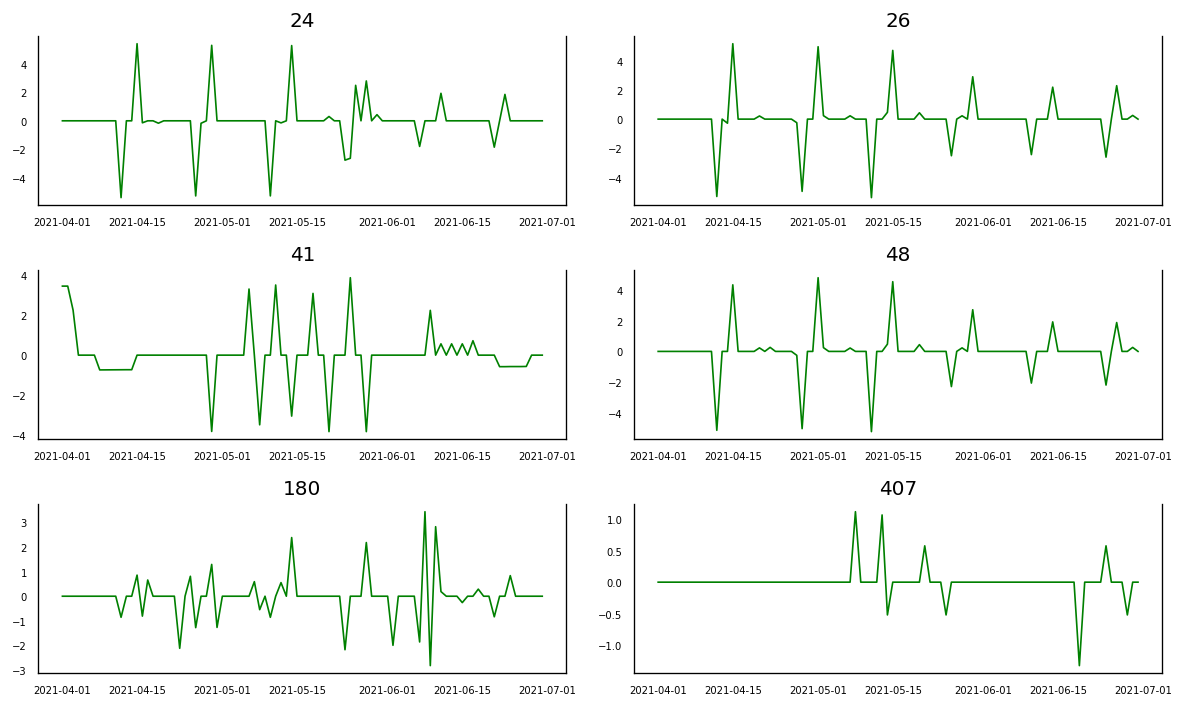

In [80]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1617[pivot1617.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1617.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [81]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3531
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8707
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [82]:
pivot1617 = pivot1617.diff().dropna()

In [83]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4048
 No. Lags Chosen       = 12
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9773
 No. Lags Chosen       = 7
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [84]:
cointegration_test(pivot1617)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  326.07    > 111.7797  =>   True
26     ::  235.66    > 83.9383   =>   True
41     ::  172.18    > 60.0627   =>   True
48     ::  121.82    > 40.1749   =>   True
180    ::  78.8      > 24.2761   =>   True
407    ::  45.45     > 12.3212   =>   True
490    ::  15.19     > 4.1296    =>   True


In [85]:

#VAR model on df_pivot
model = VAR(pivot1617)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-2.374,-2.169,0.09307,-2.292
1,-3.936,-2.292*,0.01961,-3.276*
2,-4.269,-1.187,0.01442*,-3.031
3,-4.125,0.3947,0.01776,-2.311
4,-4.219,1.739,0.01840,-1.827
5,-4.227,3.169,0.02284,-1.258
6,-4.556,4.278,0.02365,-1.009
7,-4.711,5.562,0.03586,-0.5868
8,-6.482*,5.229,0.01494,-1.780


In [86]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:37
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    5.22924
Nobs:                     82.0000    HQIC:                  -1.77982
Log likelihood:          -149.729    FPE:                  0.0149354
AIC:                     -6.48150    Det(Omega_mle):     0.000371373
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.010662         0.235508            0.045           0.964
L1.24         -0.730985         0.266489           -2.743           0.006
L1.26          0.117701         2.667545            0.044           0.965
L1.41          0.

# PIVOT 1776

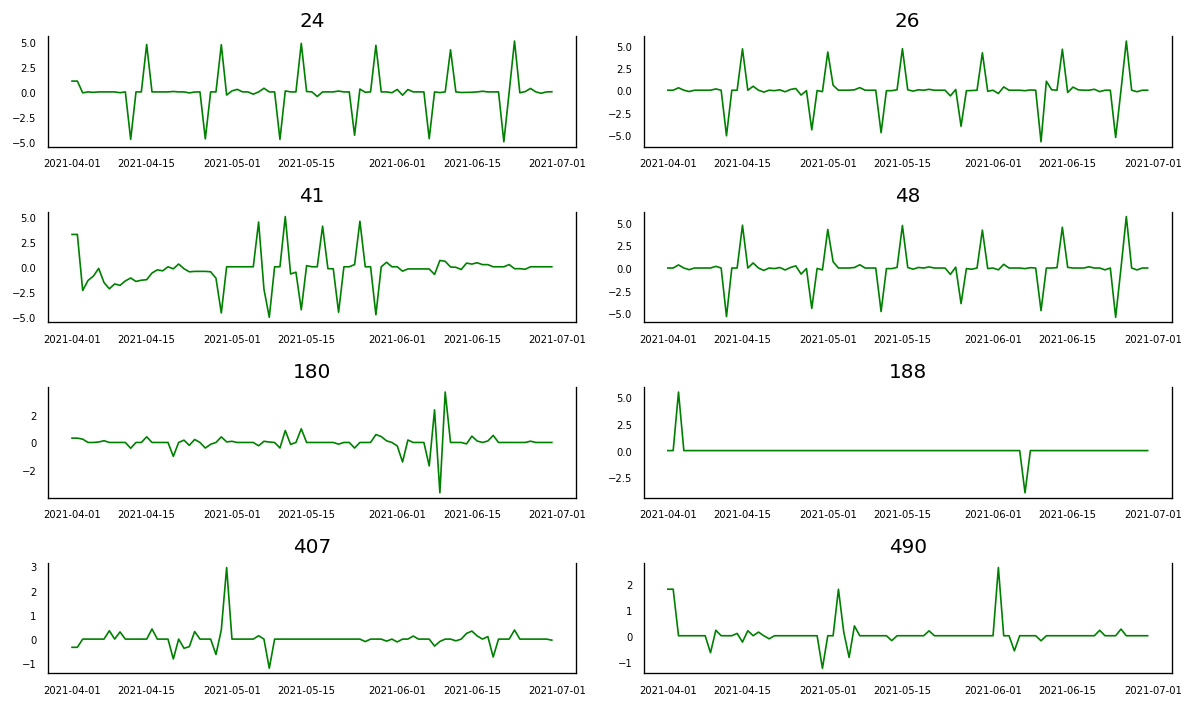

In [87]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1776[pivot1776.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1776.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [88]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.5903
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.141
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [89]:
cointegration_test(pivot1776)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  320.22    > 143.6691  =>   True
26     ::  221.45    > 111.7797  =>   True
41     ::  146.96    > 83.9383   =>   True
48     ::  97.94     > 60.0627   =>   True
180    ::  57.37     > 40.1749   =>   True
188    ::  36.9      > 24.2761   =>   True
407    ::  20.9      > 12.3212   =>   True
490    ::  6.54      > 4.1296    =>   True


In [90]:

#VAR model on df_pivot
model = VAR(pivot1776)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-6.666,-6.433*,0.001274,-6.572
1,-7.441,-5.343,0.0005908,-6.598*
2,-7.510,-3.547,0.0005740,-5.918
3,-8.279,-2.450,0.0002963,-5.937
4,-8.052,-0.3580,0.0004617,-4.961
5,-9.076,0.4832,0.0002440*,-5.235
6,-9.348,2.076,0.0003556,-4.758
7,-10.03,3.263,0.0005286,-4.687
8,-12.59*,2.568,0.0002583,-6.498


In [91]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:42
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.56800
Nobs:                     83.0000    HQIC:                  -6.49808
Log likelihood:           100.151    FPE:                0.000258252
AIC:                     -12.5862    Det(Omega_mle):     2.52682e-06
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.138111         0.468657            0.295           0.768
L1.24         -0.275265         0.301621           -0.913           0.361
L1.26          0.457887         6.314285            0.073           0.942
L1.41         -0.

# PIVOT 624

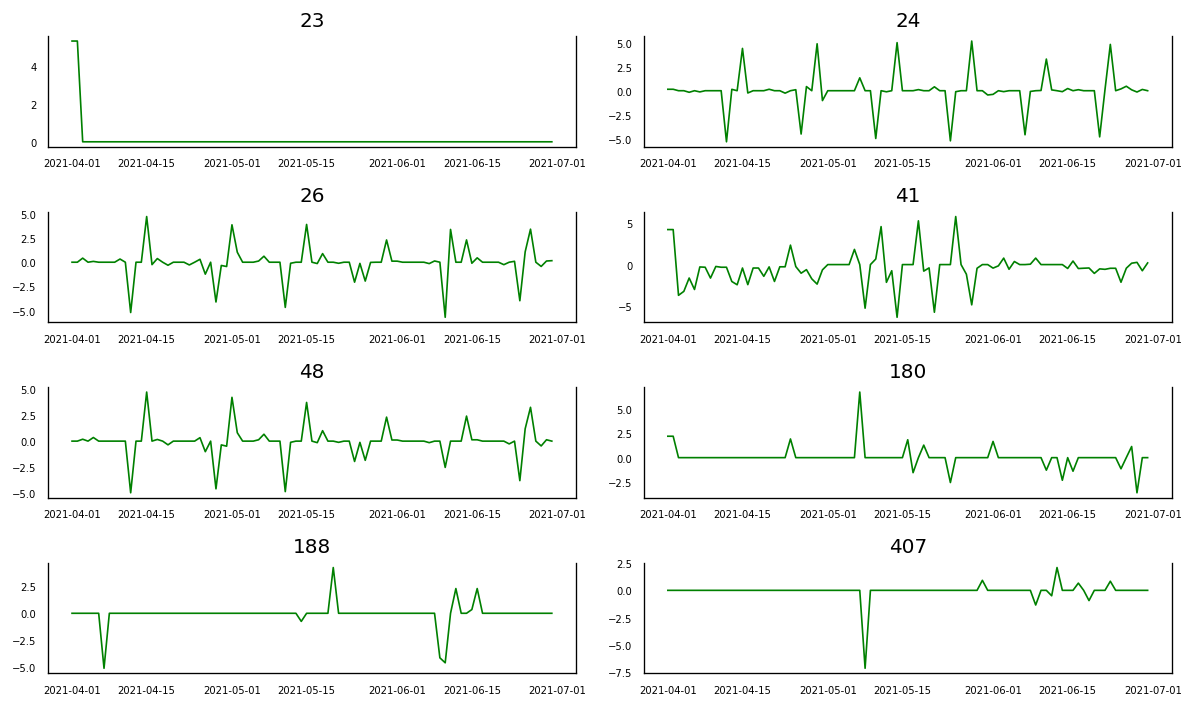

In [92]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot624[pivot624.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot624.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

dropping the seller 23 because it has too many null values

In [93]:
pivot624.drop(23,axis=1,inplace=True)

In [94]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.9474
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9623
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [95]:
cointegration_test(pivot624)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  233.66    > 143.6691  =>   True
26     ::  158.97    > 111.7797  =>   True
41     ::  110.63    > 83.9383   =>   True
48     ::  71.07     > 60.0627   =>   True
180    ::  42.36     > 40.1749   =>   True
188    ::  27.32     > 24.2761   =>   True
407    ::  15.28     > 12.3212   =>   True
490    ::  6.16      > 4.1296    =>   True


In [96]:

#VAR model on df_pivot
model = VAR(pivot624)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.4973,0.7304*,1.644,0.5909*
1,0.03991,2.138,1.048,0.8829
2,-0.1825,3.781,0.8733,1.410
3,-0.3757,5.453,0.8013,1.966
4,-0.2948,7.399,1.079,2.796
5,-0.7634,8.795,0.9939,3.077
6,-1.208,10.22,1.219,3.382
7,-1.980,11.31,1.649,3.359
8,-5.389*,9.765,0.3450*,0.6992


In [97]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:06:47
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    9.76532
Nobs:                     83.0000    HQIC:                  0.699238
Log likelihood:          -198.537    FPE:                   0.344983
AIC:                     -5.38886    Det(Omega_mle):      0.00337543
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.196777         0.362990            0.542           0.588
L1.24          0.237480         0.227210            1.045           0.296
L1.26          0.714858         1.438914            0.497           0.619
L1.41         -0.

# Grangers causation coded_cat1

In [98]:
from statsmodels.tsa.stattools import grangercausalitytests

Function build to have the grangers matrix

In [99]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var for var in variables]
        df.index = [var  for var in variables]
        return df

In [100]:
grangers_causation_matrix(pivot1354, variables = pivot1354.columns)

,24,26,41,48,180,188,407,490
24,1.0000,0.2791,0.0019,0.3958,0.6283,0.6520,0.0377,0.7823
26,0.0002,1.0000,0.0931,0.1526,0.0015,0.0374,0.2148,0.0419
41,0.0538,0.3805,1.0000,0.3646,0.0024,0.1552,0.0294,0.0289
48,0.0004,0.2182,0.0579,1.0000,0.0366,0.0289,0.1856,0.0533
180,0.4316,0.1579,0.0076,0.2244,1.0000,0.2581,0.0709,0.0851
188,0.1250,0.8638,0.2304,0.7402,0.6461,1.0000,0.6577,0.3327
407,0.0317,0.1563,0.0156,0.5146,0.0803,0.3131,1.0000,0.0744
490,0.4491,0.0022,0.0204,0.0475,0.0340,0.6371,0.2772,1.0000


compute the grangers causalty test for each of the category

In [101]:
for i in pdsecond.coded_cat1.unique():
    globals()['grangers{}'.format(i)] = grangers_causation_matrix(globals()['pivot{}'.format(i)], variables = globals()['pivot{}'.format(i)].columns)

Based on the grangers causation:

In [102]:

print('Accordingly with the grangers causalty test:')

for j in pdsecond.coded_cat1.unique():
    print(f'\n In the category {j}')
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            print(f'Seller {i} is the leader and', globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values ,'followers')
        else:
            print(f'Seller {i} has no follower')


Accordingly with the grangers causalty test:

 In the category 1375
Seller 24 is the leader and [ 26  48 180 407] followers
Seller 26 is the leader and [188] followers
Seller 41 is the leader and [24] followers
Seller 48 is the leader and [188] followers
Seller 180 has no follower
Seller 188 is the leader and [ 41 490] followers
Seller 407 is the leader and [24] followers
Seller 490 is the leader and [41] followers

 In the category 2180
Seller 24 is the leader and [ 26  41  48 180 188] followers
Seller 26 is the leader and [24 48] followers
Seller 41 is the leader and [ 24  26  48 180] followers
Seller 48 is the leader and [24 26] followers
Seller 180 is the leader and [ 41 490] followers
Seller 188 is the leader and [ 24  26  41  48 180] followers
Seller 407 has no follower
Seller 490 is the leader and [ 41 188] followers

 In the category 1676
Seller 24 is the leader and [ 26  41  48 188 407 490] followers
Seller 26 has no follower
Seller 41 is the leader and [ 24  26  48 180 490] f

Insert the results into a DataFrame: the dataframe show the followers of each seller (leader), on columns, for each category

In [103]:
leader = {}
for j in pdsecond.coded_cat1.unique():
    follower = {}
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            follower[i] = list(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values)
    leader[j] = follower           

matrix = pd.DataFrame(leader).T
matrix

,24,26,41,48,188,407,490,180
1375,"[26, 48, 180, 407]",[188],[24],[188],"[41, 490]",[24],[41],NaN
2180,"[26, 41, 48, 180, 188]","[24, 48]","[24, 26, 48, 180]","[24, 26]","[24, 26, 41, 48, 180]",NaN,"[41, 188]","[41, 490]"
1676,"[26, 41, 48, 188, 407, 490]",NaN,"[24, 26, 48, 180, 490]",[490],"[24, 26, 41, 48, 180, 407]","[26, 48, 188]","[26, 41, 180]","[41, 407]"
885,"[26, 48]",NaN,NaN,NaN,"[41, 407]",NaN,[24],NaN
2259,"[26, 48, 188]",[48],"[24, 26, 180]",NaN,"[24, 26, 41, 48, 180]",[490],"[180, 188]","[41, 407]"
1163,"[26, 41, 48, 490]",[188],"[24, 48, 180, 490]","[26, 188]",[180],[26],"[24, 41, 188]",[41]
1127,"[26, 41, 48, 180]","[24, 180]","[24, 407]","[24, 180]",[41],[24],NaN,"[26, 48]"
1354,"[26, 48, 407]",[490],"[24, 180, 407, 490]",[490],"[26, 48]","[24, 41]","[26, 41]","[26, 41, 48, 490]"
624,"[26, 41, 48]",[180],"[24, 26, 48, 490]",[26],NaN,"[24, 26, 41, 48, 490]","[24, 48, 407]","[41, 48, 407]"
2880,"[26, 48, 407, 490]",NaN,"[24, 26, 48, 180, 188, 490]",NaN,[407],NaN,"[41, 180]",[41]


In [104]:
matrix0 = matrix.fillna(0)
follower_mode = []
for i in matrix0.columns:
    mode=[]
    for j in matrix0.index:
        if matrix0[i][j] != 0:
            for g in range(len(matrix0[i][j])):
                mode.append(matrix0[i][j][g])
    print(f'The more recurrent follower for seller {i} is {max(set(mode), key=mode.count)}, that is a follower in {mode.count(max(set(mode), key=mode.count))} categories')
    follower_mode.append(max(set(mode), key=mode.count))

The more recurrent follower for seller 24 is 48, that is a follower in 12 categories
The more recurrent follower for seller 26 is 490, that is a follower in 2 categories
The more recurrent follower for seller 41 is 24, that is a follower in 9 categories
The more recurrent follower for seller 48 is 26, that is a follower in 4 categories
The more recurrent follower for seller 188 is 41, that is a follower in 6 categories
The more recurrent follower for seller 407 is 24, that is a follower in 4 categories
The more recurrent follower for seller 490 is 41, that is a follower in 7 categories
The more recurrent follower for seller 180 is 41, that is a follower in 7 categories


In [105]:
matrix2 = matrix.append(pd.Series(follower_mode, index=matrix.columns, name='followers mode'))

In [106]:
matrix2

,24,26,41,48,188,407,490,180
1375,"[26, 48, 180, 407]",[188],[24],[188],"[41, 490]",[24],[41],NaN
2180,"[26, 41, 48, 180, 188]","[24, 48]","[24, 26, 48, 180]","[24, 26]","[24, 26, 41, 48, 180]",NaN,"[41, 188]","[41, 490]"
1676,"[26, 41, 48, 188, 407, 490]",NaN,"[24, 26, 48, 180, 490]",[490],"[24, 26, 41, 48, 180, 407]","[26, 48, 188]","[26, 41, 180]","[41, 407]"
885,"[26, 48]",NaN,NaN,NaN,"[41, 407]",NaN,[24],NaN
2259,"[26, 48, 188]",[48],"[24, 26, 180]",NaN,"[24, 26, 41, 48, 180]",[490],"[180, 188]","[41, 407]"
1163,"[26, 41, 48, 490]",[188],"[24, 48, 180, 490]","[26, 188]",[180],[26],"[24, 41, 188]",[41]
1127,"[26, 41, 48, 180]","[24, 180]","[24, 407]","[24, 180]",[41],[24],NaN,"[26, 48]"
1354,"[26, 48, 407]",[490],"[24, 180, 407, 490]",[490],"[26, 48]","[24, 41]","[26, 41]","[26, 41, 48, 490]"
624,"[26, 41, 48]",[180],"[24, 26, 48, 490]",[26],NaN,"[24, 26, 41, 48, 490]","[24, 48, 407]","[41, 48, 407]"
2880,"[26, 48, 407, 490]",NaN,"[24, 26, 48, 180, 188, 490]",NaN,[407],NaN,"[41, 180]",[41]


# Plot

In [107]:
pdsecond0 = pdsecond.fillna(0)
pdsecond0['price_change_sign'] = np.where(pdsecond.price_change == 0, 1, 0)
prod_p_var = pdsecond0.groupby(['product_id','coded_cat1'])['price_change_sign'].sum()
prod_p_var = pd.DataFrame(prod_p_var)
prod_p_var.reset_index(inplace=True)
prod_p_var.sort_values('price_change_sign', ascending=False, inplace=True)

In [108]:
prod_p_var[prod_p_var.coded_cat1 == 1163].head(30)

,product_id,coded_cat1,price_change_sign
2519,144965,1163,471
3573,156666,1163,470
2056,141765,1163,437
3572,156665,1163,434
3695,157154,1163,433
255,105911,1163,429
4225,161236,1163,424
1287,131971,1163,423
2904,151991,1163,422
2055,141764,1163,420


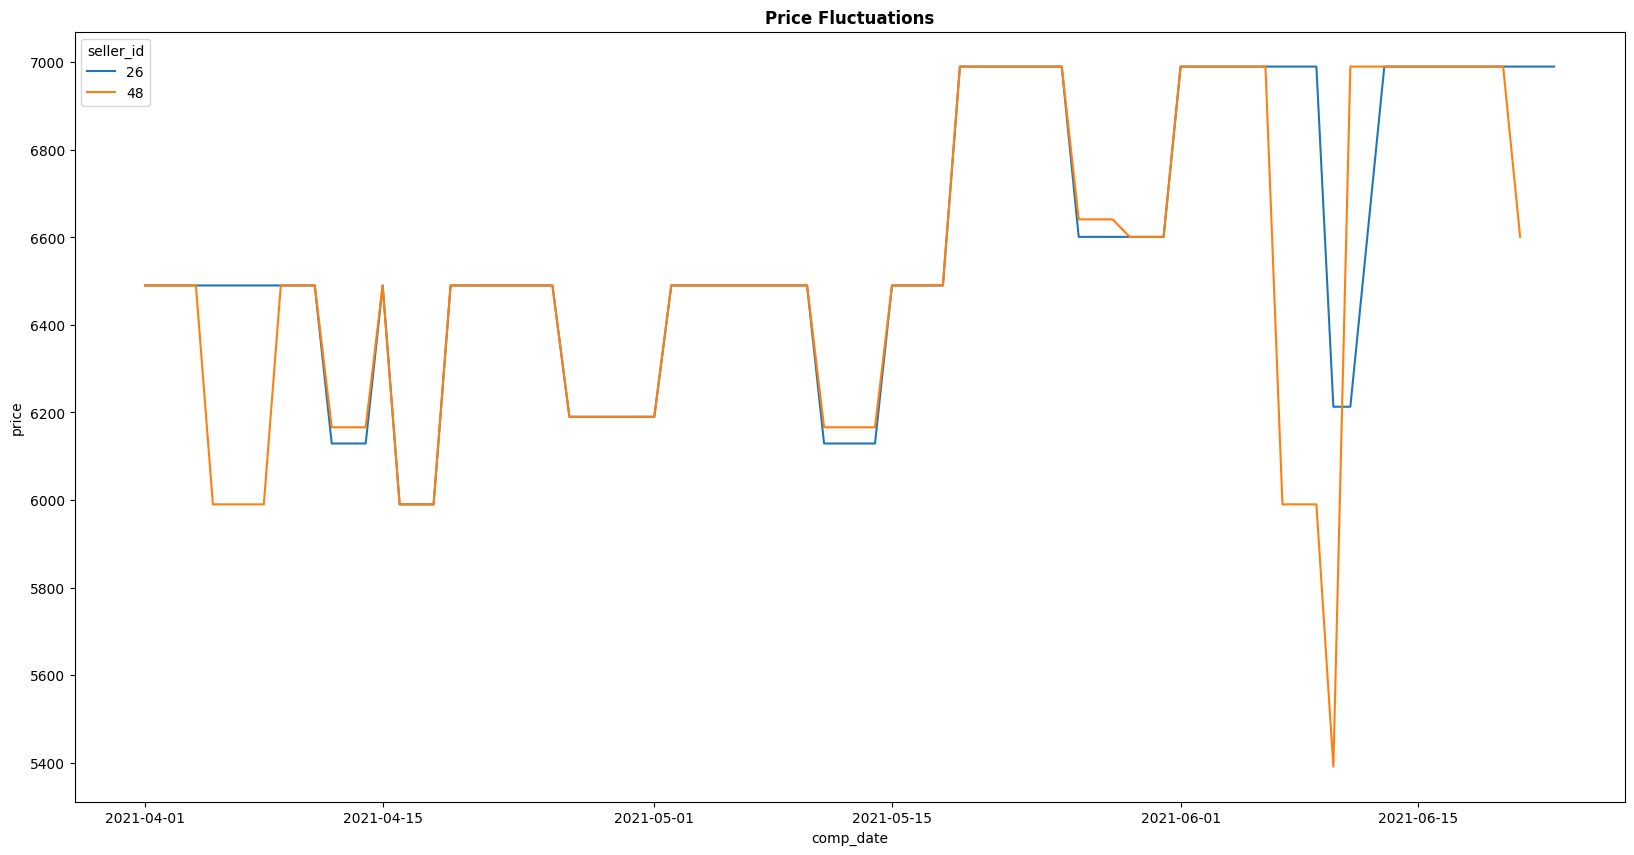

In [109]:
pdsecond['comp_date'] = pd.to_datetime(pdsecond['comp_date'])
plt.figure(figsize=(20,10))
#plt.style.use("dark_background")
df = pdsecond[(pdsecond.product_id == 135765) & (pdsecond.seller_id.isin([48, 26, 407, 490]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
#sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
#sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')
plt.title('Price Fluctuations', size = 12, fontweight="bold")
plt.savefig('image.png')

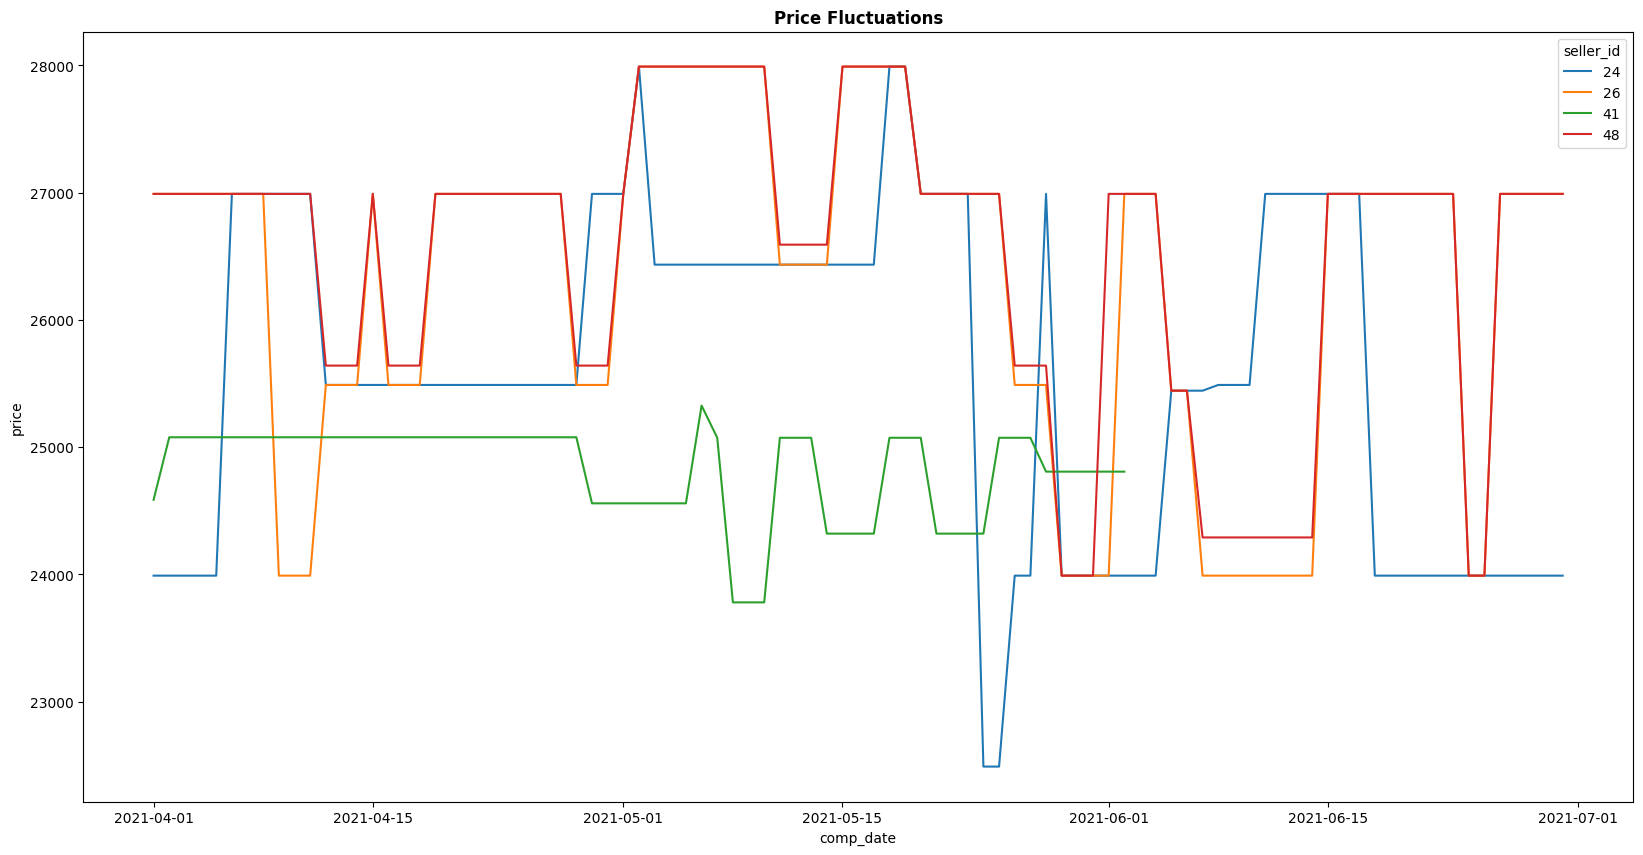

In [110]:
pdsecond['comp_date'] = pd.to_datetime(pdsecond['comp_date'])
plt.figure(figsize=(20,10))
#plt.style.use("dark_background")
df = pdsecond[(pdsecond.product_id == 135135) & (pdsecond.seller_id.isin([24, 26, 41, 48, 188]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
#sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
#sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')
plt.title('Price Fluctuations', size = 12, fontweight="bold")
plt.savefig('image.png')